What does this notebook do:

    - loads the charge distribution data.
    - computes the net heating per grain, full calculation.
    - takes the GTn parameter and computes the parametric net heating.
    - compares both distributions and gives the percentiles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pickle
import numpy as np
from   matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import time

import compute_charge_dist as fz
import PeHeat_Functions as peh
import parametric_fz as fzpar
import parametric_PeHeat as parPeH

Loading the library to compute the charge distribution of dust grains.


In [2]:
def index_fz(npoints, zminmax, fdist):

    ffz = []
    cum = 0
    for index in range(npoints):
        zmin = zminmax[index*2]
        zmax = zminmax[index*2+1]
        znum = int(abs(zmin) + zmax + 1)
        
        #print(zmin, zmax)
        #print(znum)
        
        ffz.append(0)
        ffz[-1] = []
        for j in range(znum):
            fhere = fdist[cum+j]
            ffz[-1].append(fhere)
            #print("filling the array", j)
        #print(ffz[-1])
        cum += znum
    
    return ffz

---
# Now for carbonaceous

In [3]:
#grain_type = "silicate"
grain_type = "carbonaceous"

########################################################################################
pcent      = 1
grain_size = 3

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist3 = pickle.load(pkl_file)
pkl_file.close

Qabs3 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 5

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist5 = pickle.load(pkl_file)
pkl_file.close

Qabs5 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 10

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist10 = pickle.load(pkl_file)
pkl_file.close

Qabs10 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 50

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist50 = pickle.load(pkl_file)
pkl_file.close

Qabs50 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 100

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist100 = pickle.load(pkl_file)
pkl_file.close

Qabs100 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 0.1
grain_size = 500

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist500 = pickle.load(pkl_file)
pkl_file.close

Qabs500 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 0.1
grain_size = 1000

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist1000 = pickle.load(pkl_file)
pkl_file.close

Qabs1000 = fz.get_QabsTable(grain_type, grain_size)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [4]:
def Full_netHeating(grain_size, grain_type, nH, Gtot, temp, xe, zminmax, fdist, Qabs):
    """
    Given the charge distribution, and some ISM parameters, compute the net heating by a single dust grain.
    """
    Zmin_sil, Zmax_sil = fz.get_Zmin(grain_size, grain_type), fz.get_Zmax(grain_size, grain_type)
    Znum_sil = int(Zmax_sil + abs(Zmin_sil) +1)
    ZZ_sil = np.linspace(Zmin_sil, Zmax_sil, num=Znum_sil)

    Gamma_dotdot_Z_sil = np.zeros_like(ZZ_sil, dtype=np.float)

    for i in range(Znum_sil):
        Gamma_dotdot_Z_sil[i] = peh.get_Gamma_pe_dotdot(grain_size, ZZ_sil[i], grain_type, 0.0, Qabs, G0=1.7)

    Gamma_a = np.zeros_like(nH, dtype=np.float)
    Cooling = np.zeros_like(nH, dtype=np.float)
    cum = 0

    #for index in range(10):
    for index in range(len(Gamma_a)):

        zmin = zminmax[index*2]
        zmax = zminmax[index*2+1]
        znum = int(abs(zmin) + zmax + 1)

        Gamma_dotdot_Z_sil_scaled = Gamma_dotdot_Z_sil*(Gtot[index]/1.7)

        ZZfz = np.arange(zmin, zmax+1, 1)
        ffz  = fdist[index]
        #print(ZZfz)
        #print(ffz)

        Gamma_a[index]= peh.Gamma_per_grain(ZZ_sil, Gamma_dotdot_Z_sil_scaled, ZZfz, ffz)
        
        #Cooling[index] = peh.Cool_per_Grain(grain_size, grain_type, ZZfz, ffz, nH[index], xe[index], temp[index])

    netHeat = Gamma_a #- Cooling
    
    return netHeat

In [5]:
fdist3 = index_fz(len(cdist3["nH"]), cdist3["zminmax"], cdist3["fdist"])
fdist5 = index_fz(len(cdist5["nH"]), cdist5["zminmax"], cdist5["fdist"])
fdist10 = index_fz(len(cdist10["nH"]), cdist10["zminmax"], cdist10["fdist"])

In [6]:
nH3, Gtot3, temp3, xe3, zminmax3, fdist3                   = cdist3["nH"], cdist3["G"]+cdist3["G_CR"], cdist3["temp"],cdist3["new_xe"], cdist3["zminmax"], fdist3
nH5, Gtot5, temp5, xe5, zminmax5, fdist5                   = cdist5["nH"], cdist5["G"]+cdist5["G_CR"], cdist5["temp"],cdist5["new_xe"], cdist5["zminmax"], fdist5
nH10, Gtot10, temp10, xe10, zminmax10, fdist10             = cdist10["nH"], cdist10["G"]+cdist10["G_CR"], cdist10["temp"],cdist10["new_xe"], cdist10["zminmax"], fdist10
nH50, Gtot50, temp50, xe50, zminmax50, fdist50             = cdist50["nH"], cdist50["G"]+cdist50["G_CR"], cdist50["temp"],cdist50["new_xe"], cdist50["zminmax"], cdist50["fdist"]
nH100, Gtot100, temp100, xe100, zminmax100, fdist100       = cdist100["nH"], cdist100["G"]+cdist100["G_CR"], cdist100["temp"],cdist100["new_xe"], cdist100["zminmax"], cdist100["fdist"]
nH500, Gtot500, temp500, xe500, zminmax500, fdist500       = cdist500["nH"], cdist500["G"]+cdist500["G_CR"], cdist500["temp"],cdist500["new_xe"], cdist500["zminmax"], cdist500["fdist"]
nH1000, Gtot1000, temp1000, xe1000, zminmax1000, fdist1000 = cdist1000["nH"], cdist1000["G"]+cdist1000["G_CR"], cdist1000["temp"],cdist1000["new_xe"], cdist1000["zminmax"], cdist1000["fdist"]

In [7]:
netHeat3 = Full_netHeating(3.5, grain_type, nH3, Gtot3, temp3, xe3, zminmax3, fdist3, Qabs3)
netHeat5 = Full_netHeating(5., grain_type, nH5, Gtot5, temp5, xe5, zminmax5, fdist5, Qabs5)
netHeat10 = Full_netHeating(10., grain_type, nH10, Gtot10, temp10, xe10, zminmax10, fdist10, Qabs10)
netHeat50 = Full_netHeating(50., grain_type, nH50, Gtot50, temp50, xe50, zminmax50, fdist50, Qabs50)
netHeat100 = Full_netHeating(100., grain_type, nH100, Gtot100, temp100, xe100, zminmax100, fdist100, Qabs100)
netHeat500 = Full_netHeating(500., grain_type, nH500, Gtot500, temp500, xe500, zminmax500, fdist500, Qabs500)
netHeat1000 = Full_netHeating(1000., grain_type, nH1000, Gtot1000, temp1000, xe1000, zminmax1000, fdist1000, Qabs1000)

In [8]:
netHeat3_par,netHeat5_par,netHeat10_par,netHeat50_par = np.zeros_like(Gtot3), np.zeros_like(Gtot3), np.zeros_like(Gtot3), np.zeros_like(Gtot3)
netHeat100_par,netHeat500_par,netHeat1000_par = np.zeros_like(Gtot3), np.zeros_like(Gtot500), np.zeros_like(Gtot1000)

for i in range(85943):
    netHeat3_par[i]    = parPeH.get_Gamma_dot_par(Gtot3[i],    temp3[i],    nH3[i]*xe3[i],         3.5, grain_type)
    netHeat5_par[i]    = parPeH.get_Gamma_dot_par(Gtot5[i],    temp5[i],    nH5[i]*xe5[i],          5., grain_type)
    netHeat10_par[i]   = parPeH.get_Gamma_dot_par(Gtot10[i],   temp10[i],   nH10[i]*xe10[i],       10., grain_type)
    netHeat50_par[i]   = parPeH.get_Gamma_dot_par(Gtot50[i],   temp50[i],   nH50[i]*xe50[i],       50., grain_type)
    netHeat100_par[i]  = parPeH.get_Gamma_dot_par(Gtot100[i],  temp100[i],  nH100[i]*xe100[i],    100., grain_type)

for i in range(len(Gtot500)):
    netHeat500_par[i]  = parPeH.get_Gamma_dot_par(Gtot500[i],  temp500[i],  nH500[i]*xe500[i],    500., grain_type)
for i in range(len(Gtot1000)):
    netHeat1000_par[i] = parPeH.get_Gamma_dot_par(Gtot1000[i], temp1000[i], nH1000[i]*xe1000[i], 1000., grain_type)

In [9]:
netHeat3_par,netHeat5_par,netHeat10_par,netHeat50_par = np.zeros_like(Gtot3), np.zeros_like(Gtot3), np.zeros_like(Gtot3), np.zeros_like(Gtot3)
netHeat100_par,netHeat500_par,netHeat1000_par = np.zeros_like(Gtot3), np.zeros_like(Gtot500), np.zeros_like(Gtot1000)

for i in range(85943):
    netHeat3_par[i]    = parPeH.get_Gamma_dot_par(Gtot3[i],    temp3[i],    nH3[i]*xe3[i],         3.5, grain_type)
    netHeat5_par[i]    = parPeH.get_Gamma_dot_par(Gtot5[i],    temp5[i],    nH5[i]*xe5[i],          5., grain_type)
    netHeat10_par[i]   = parPeH.get_Gamma_dot_par(Gtot10[i],   temp10[i],   nH10[i]*xe10[i],       10., grain_type)
    netHeat50_par[i]   = parPeH.get_Gamma_dot_par(Gtot50[i],   temp50[i],   nH50[i]*xe50[i],       50., grain_type)
    netHeat100_par[i]  = parPeH.get_Gamma_dot_par(Gtot100[i],  temp100[i],  nH100[i]*xe100[i],    100., grain_type)

for i in range(len(Gtot500)):
    netHeat500_par[i]  = parPeH.get_Gamma_dot_par(Gtot500[i],  temp500[i],  nH500[i]*xe500[i],    500., grain_type)
for i in range(len(Gtot1000)):
    netHeat1000_par[i] = parPeH.get_Gamma_dot_par(Gtot1000[i], temp1000[i], nH1000[i]*xe1000[i], 1000., grain_type)

In [10]:
differror3    = (netHeat3    - netHeat3_par)    / netHeat3
differror5    = (netHeat5    - netHeat5_par)    / netHeat5
differror10   = (netHeat10   - netHeat10_par)   / netHeat10
differror50   = (netHeat50   - netHeat50_par)   / netHeat50
differror100  = (netHeat100  - netHeat100_par)  / netHeat100
differror500  = (netHeat500  - netHeat500_par)  / netHeat500
differror1000 = (netHeat1000 - netHeat1000_par) / netHeat1000

In [11]:
# Compute relative error
relerror3    = np.percentile((np.abs(netHeat3    - 1.2*netHeat3_par)    / netHeat3),    [25,50,75])*100
relerror5    = np.percentile((np.abs(netHeat5    - 1.2*netHeat5_par)    / netHeat5),    [25,50,75])*100
relerror10   = np.percentile((np.abs(netHeat10   - 1.2*netHeat10_par)   / netHeat10),   [25,50,75])*100
relerror50   = np.percentile((np.abs(netHeat50   - 1.2*netHeat50_par)   / netHeat50),   [25,50,75])*100
relerror100  = np.percentile((np.abs(netHeat100  - 1.2*netHeat100_par)  / netHeat100),  [25,50,75])*100
relerror500  = np.percentile((np.abs(netHeat500  - 1.2*netHeat500_par)  / netHeat500),  [25,50,75])*100
relerror1000 = np.percentile((np.abs(netHeat1000 - 1.2*netHeat1000_par) / netHeat1000), [25,50,75])*100

In [12]:
# Print table
print("")
print(" Relative error table")
print("3.5 \t & %.1f \t & %.1f \t & %.1f"%(relerror3[0],     relerror3[1], relerror3[2]))
print("5 \t & %.1f \t & %.1f \t & %.1f"%(  relerror5[0],     relerror5[1], relerror5[2]))
print("10 \t & %.1f \t & %.1f \t & %.1f"%( relerror10[0],    relerror10[1], relerror10[2]))
print("50 \t & %.1f \t & %.1f \t & %.1f"%( relerror50[0],    relerror50[1], relerror50[2]))
print("100 \t & %.1f \t & %.1f \t & %.1f"%(relerror100[0],   relerror100[1], relerror100[2]))
print("500 \t & %.1f \t & %.1f \t & %.1f"%(relerror500[0],   relerror500[1], relerror500[2]))
print("1000 \t & %.1f \t & %.1f \t & %.1f"%(relerror1000[0], relerror1000[1], relerror1000[2]))


 Relative error table
3.5 	 & 15.2 	 & 49.0 	 & 64.7
5 	 & 8.3 	 & 17.7 	 & 26.4
10 	 & 57.7 	 & 67.1 	 & 70.5
50 	 & 19.9 	 & 31.7 	 & 38.8
100 	 & 20.1 	 & 37.7 	 & 41.3
500 	 & 7.1 	 & 17.9 	 & 19.8
1000 	 & 14.3 	 & 24.0 	 & 25.4


In [48]:
# Compute relative error
relerror3    = np.percentile((np.abs(netHeat3    - 1.0*netHeat3_par)    / netHeat3),    [25,50,75])*100
relerror5    = np.percentile((np.abs(netHeat5    - 1.2*netHeat5_par)    / netHeat5),    [25,50,75])*100
relerror10   = np.percentile((np.abs(netHeat10   - 1.0*netHeat10_par)   / netHeat10),   [25,50,75])*100
relerror50   = np.percentile((np.abs(netHeat50   - 1.3*netHeat50_par)   / netHeat50),   [25,50,75])*100
relerror100  = np.percentile((np.abs(netHeat100  - 1.3*netHeat100_par)  / netHeat100),  [25,50,75])*100
relerror500  = np.percentile((np.abs(netHeat500  - 1.0*netHeat500_par)  / netHeat500),  [25,50,75])*100
relerror1000 = np.percentile((np.abs(netHeat1000 - 1.0*netHeat1000_par) / netHeat1000), [25,50,75])*100

In [49]:
# Print table

print("")
print(" Relative error table")
print("3.5 \t & %.1f \t & %.1f \t & %.1f"%(relerror3[0],     relerror3[1], relerror3[2]))
print("5 \t & %.1f \t & %.1f \t & %.1f"%(  relerror5[0],     relerror5[1], relerror5[2]))
print("10 \t & %.1f \t & %.1f \t & %.1f"%( relerror10[0],    relerror10[1], relerror10[2]))
print("50 \t & %.1f \t & %.1f \t & %.1f"%( relerror50[0],    relerror50[1], relerror50[2]))
print("100 \t & %.1f \t & %.1f \t & %.1f"%(relerror100[0],   relerror100[1], relerror100[2]))
print("1000 \t & %.1f \t & %.1f \t & %.1f"%(relerror1000[0], relerror1000[1], relerror1000[2]))


 Relative error table
3.5 	 & 4.0 	 & 12.2 	 & 37.9
5 	 & 10.6 	 & 16.8 	 & 23.4
10 	 & 0.7 	 & 2.0 	 & 7.1
50 	 & 5.9 	 & 6.5 	 & 8.1
100 	 & 6.0 	 & 8.3 	 & 14.7
1000 	 & 3.9 	 & 4.9 	 & 12.4


In [17]:
%matplotlib inline

In [32]:
print(len(netHeat1000),len(netHeat1000_par))

(8579, 8579)


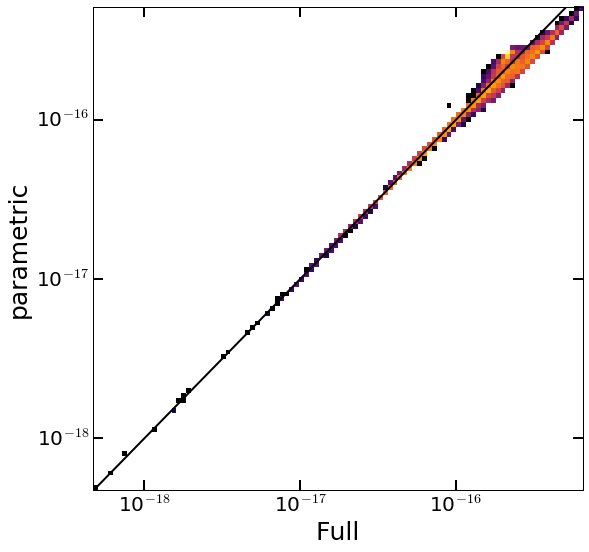

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.14, 0.11, 0.85, 0.84])
from matplotlib.ticker import MaxNLocator
def format_func(value, tick_number):
    return "10$^{%i}$"%value

ax.hist2d(np.log10(netHeat500), np.log10(netHeat500_par*1.0), bins=100, norm=LogNorm(), cmap="inferno")
ax.plot([-25, -15],[-25, -15], "-k", linewidth=2)
#ax.set_ylabel("T [K]", fontsize=25)
#
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=20, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=20, direction="in")

#ax.set_ylim(-0.9, 4.99)
ax.set_ylabel("parametric", fontsize=25)
ax.set_xlabel("Full", fontsize=25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#ax.set_yscale("log")
fig.show()
